In [12]:
import numpy as np
from time import sleep
from random import random, randint, choice
import pickle
from math import cos, sin, sqrt, exp, pi
from matplotlib import animation, rc
import matplotlib.pyplot as plt
from IPython.display import HTML

import winsound
frequency = 1000
duration = 1000

from tqdm import tqdm as tqdm_base
def tqdm(*args, **kwargs):
    if hasattr(tqdm_base, '_instances'):
        for instance in list(tqdm_base._instances):
            tqdm_base._decr_instances(instance)
    return tqdm_base(*args, **kwargs)


In [13]:
class Reacher:
    def __init__(self, arm_nbr=2, α_res=100, x_res=100, reward_reach=100, reach_distance=0.5, reward_gradient_multiplier=1, respawn_target=False):
        self.arm_nbr = arm_nbr
        self.arm_length = sqrt(2)*x_res/(2*arm_nbr)
        self.α_res = α_res
        self.x_res = x_res
        self.reward_reach = reward_reach
        self.reach_distance = reach_distance
        self.reward_gradient_multiplier = reward_gradient_multiplier
        self.respawn_target = respawn_target
        self.Rs = {}
        self.Tss = {}
    
    def randomPolicy(self):
        π = {state: choice(self.actions(state)) for state in self.states()}
        return π

    def states(self):
        if self.arm_nbr==1:
            return tuple((α1,x1,x2) for α1 in range(self.α_res) for x1 in range(int(-self.x_res/2),int(self.x_res/2)) for x2 in range(int(-self.x_res/2),int(self.x_res/2)))
        elif self.arm_nbr==2:
            return tuple((α1,α2,x1,x2) for α1 in range(self.α_res) for α2 in range(self.α_res) for x1 in range(int(-self.x_res/2),int(self.x_res/2)) for x2 in range(int(-self.x_res/2),int(self.x_res/2)))
        elif self.arm_nbr==3:
            return tuple((α1,α2,α3,x1,x2) for α1 in range(self.α_res) for α2 in range(self.α_res) for α3 in range(self.α_res) for x1 in range(int(-self.x_res/2),int(self.x_res/2)) for x2 in range(int(-self.x_res/2),int(self.x_res/2)))

    def startingStates(self):
        if self.arm_nbr==1:
            return tuple((0,x1,x2) for x1 in range(int(-self.x_res/2),int(self.x_res/2)) for x2 in range(int(-self.x_res/2),int(self.x_res/2)))
        elif self.arm_nbr==2:
            return tuple((0,self.α_res/2,x1,x2) for x1 in range(int(-self.x_res/2),int(self.x_res/2)) for x2 in range(int(-self.x_res/2),int(self.x_res/2)))
        elif self.arm_nbr==3:
            return tuple((0,self.α_res/2,self.α_res/2,x1,x2) for x1 in range(int(-self.x_res/2),int(self.x_res/2)) for x2 in range(int(-self.x_res/2),int(self.x_res/2)))

    def actions(self, state=None):
        if self.arm_nbr==1:
            return tuple(tuple(a1) for a1 in [-1,0,+1])
        elif self.arm_nbr==2:
            return tuple((a1,a2) for a1 in [-1,0,+1] for a2 in [-1,0,+1])
        elif self.arm_nbr==3:
            return tuple((a1,a2,a3) for a1 in [-1,0,+1] for a2 in [-1,0,+1] for a3 in [-1,0,+1]) 

    def R(self, state):
        if state in self.Rs: return self.Rs[state]
        if self.arm_nbr==1:
            α1,x1,x2 = state
            α1 = 2*pi*α1/float(self.α_res)
            y1,y2 = (self.arm_length*cos(α1) , self.arm_length*sin(α1))
        elif self.arm_nbr==2:
            α1,α2,x1,x2 = state
            α1 = 2*pi*α1/float(self.α_res)
            α2 = 2*pi*(α2/float(self.α_res)-0.5)
            y1,y2 = (self.arm_length*(cos(α1)+cos(α1+α2)) , self.arm_length*(sin(α1)+sin(α1+α2)))
        elif self.arm_nbr==3:
            α1,α2,α3,x1,x2 = state
            α1 = 2*pi*α1/float(self.α_res)
            α2 = 2*pi*(α2/float(self.α_res)-0.5)
            α3 = 2*pi*(α3/float(self.α_res)-0.5)
            y1,y2 = (self.arm_length*(cos(α1)+cos(α1+α2)+cos(α1+α2+α3)) , self.arm_length*(sin(α1)+sin(α1+α2)+sin(α1+α2+α3)))
        d = sqrt((x1-y1)**2+(x2-y2)**2)
        r = self.reward_reach if d<=self.reach_distance else self.reward_gradient_multiplier*exp(-0.05*d)/self.reward_reach
        self.Rs[state] = r
        return r
    
    def T(self,state,action):
        # if (state,action) in self.Tss: return self.Tss[(state,action)]
        state_t = state
        if self.arm_nbr==1:
            α1,x1,x2 = state
            if self.respawn_target:
                y1,y2 = (self.arm_length*cos(2*pi*α1/float(self.α_res)) , self.arm_length*sin(2*pi*α1/float(self.α_res)))
                d = sqrt((x1-y1)**2+(x2-y2)**2)
                if d<=self.reach_distance:
                    x1 = randint(-self.x_res/2,self.x_res/2-1)
                    x2 = randint(-self.x_res/2,self.x_res/2-1)
            α1 += action[0]
            α1 %= self.α_res
            state = (α1,x1,x2)
        elif self.arm_nbr==2:
            α1,α2,x1,x2 = state
            if self.respawn_target:
                y1,y2 = (self.arm_length*(cos(2*pi*α1/float(self.α_res))+cos(2*pi*α1/float(self.α_res)+2*pi*(α2/float(self.α_res)-0.5))) , self.arm_length*(sin(2*pi*α1/float(self.α_res))+sin(2*pi*α1/float(self.α_res)+2*pi*(α2/float(self.α_res)-0.5))))
                d = sqrt((x1-y1)**2+(x2-y2)**2)
                if d<=self.reach_distance:
                    x1 = randint(-int(self.x_res/2),int(self.x_res/2)-1)
                    x2 = randint(-int(self.x_res/2),int(self.x_res/2)-1)
            α1 += action[0]
            α2 += action[1]
            α1 %= self.α_res
            α2 %= self.α_res
            state = (α1,α2,x1,x2)
        elif self.arm_nbr==3:
            α1,α2,α3,x1,x2 = state
            if self.respawn_target:
                y1,y2 = (self.arm_length*(cos(2*pi*α1/float(self.α_res))+cos(2*pi*α1/float(self.α_res)+2*pi*(α2/float(self.α_res)-0.5))+cos(2*pi*α1/float(self.α_res)+2*pi*(α2/float(self.α_res)-0.5)+2*pi*(α3/float(self.α_res)-0.5))) , self.arm_length*(sin(2*pi*α1/float(self.α_res))+sin(2*pi*α1/float(self.α_res)+2*pi*(α2/float(self.α_res)-0.5))+sin(2*pi*α1/float(self.α_res)+2*pi*(α2/float(self.α_res)-0.5)+2*pi*(α3/float(self.α_res)-0.5))))
                d = sqrt((x1-y1)**2+(x2-y2)**2)
                if d<=self.reach_distance:
                    x1 = randint(-self.x_res/2,self.x_res/2-1)
                    x2 = randint(-self.x_res/2,self.x_res/2-1)
            α1 += action[0]
            α2 += action[1]
            α3 += action[1]
            α1 %= self.α_res
            α2 %= self.α_res
            α3 %= self.α_res
            state = (α1,α2,α3,x1,x2)
        # self.Tss[(state_t,action)] = state
        return state
    
    def Ts(self,state,action):
        return {self.T(state,action):1}
    
    def play(self, π, nbr_turns=0, position=(0,0), display=True, respawn_target=True):
        respawn_target_backup = self.respawn_target
        self.respawn_target = respawn_target
        if nbr_turns==0:
            nbr_turns = 3*self.α_res
        state = choice(self.startingStates())
        if position!=(0,0):
            state = (*state[:self.arm_nbr], *position)
        score = 0
        if display:
            fig, ax = plt.subplots()
            ax.set_xlim(-sqrt(2)*self.x_res/2, +sqrt(2)*self.x_res/2)
            ax.set_ylim(-sqrt(2)*self.x_res/2, +sqrt(2)*self.x_res/2)
            arm, = ax.plot([], [], lw=3, marker='o', color="Goldenrod")
            target, = ax.plot([], [], markersize=10, marker='o', color="IndianRed")
            def init():
                arm.set_data([], [])
                return (arm,)
            def animate(i):
                nonlocal state
                nonlocal score
                nonlocal ax
                if state not in π:
                    if display: print("State not in policy : {}".format(state))
                else:
                    action = π[state]
                state = self.T(state,action)
                score += self.R(state)
                if self.arm_nbr==1:
                    α1,x1,x2 = state
                    α1 = 2*pi*α1/float(self.α_res)
                    X = [0, self.arm_length*cos(α1)]
                    Y = [0, self.arm_length*sin(α1)]
                elif self.arm_nbr==2:
                    α1,α2,x1,x2 = state
                    α1 = 2*pi*α1/float(self.α_res)
                    α2 = 2*pi*(α2/float(self.α_res)-0.5)
                    X = [0, self.arm_length*cos(α1), self.arm_length*(cos(α1)+cos(α1+α2))]
                    Y = [0, self.arm_length*sin(α1), self.arm_length*(sin(α1)+sin(α1+α2))]
                elif self.arm_nbr==3:
                    α1,α2,α3,x1,x2 = state
                    α1 = 2*pi*α1/float(self.α_res)
                    α2 = 2*pi*(α2/float(self.α_res)-0.5)
                    α3 = 2*pi*(α3/float(self.α_res)-0.5)
                    X = [0, self.arm_length*cos(α1), self.arm_length*(cos(α1)+cos(α1+α2)), self.arm_length*(cos(α1)+cos(α1+α2)+cos(α1+α2+α3))]
                    Y = [0, self.arm_length*sin(α1), self.arm_length*(sin(α1)+sin(α1+α2)), self.arm_length*(sin(α1)+sin(α1+α2)+sin(α1+α2+α3))]
                arm.set_data(X, Y)
                target.set_data([x1],[x2])
                ax.set_title("Score : {:0.2f}".format(score))
                return (arm,)
            anim = animation.FuncAnimation(fig, animate, init_func=init, frames=nbr_turns, interval=100, blit=True)
            HTML(anim.to_jshtml())
            self.respawn_target = respawn_target_backup
            return score, anim
        else:
            for _ in range(nbr_turns):
                if state not in π:
                    if display: print("State not in policy")
                else:
                    action = π[state]
                state = self.T(state,action)
                score += self.R(state)
            self.respawn_target = respawn_target_backup
        return score

    def performance(self, π, nbr_runs=200, nbr_turns=0, respawn_target=True):
        scores = []
        for run in tqdm(range(nbr_runs)):
            scores.append(self.play(π, nbr_turns, display=False, respawn_target=respawn_target))
        return min(scores) , sum(scores)/len(scores) , max(scores)

In [14]:
from random import choice, random
import numpy as np

from tqdm import tqdm as tqdm_base
def tqdm(*args, **kwargs):
    if hasattr(tqdm_base, '_instances'):
        for instance in list(tqdm_base._instances):
            tqdm_base._decr_instances(instance)
    return tqdm_base(*args, **kwargs)

def policyDistance(π1,π2):
    return np.linalg.norm(np.array(list(π1.values()))-np.array(list(π2.values())))




#%% region[red] VALUE ITERATION
def valueIteration(mdp, ε, γ, max_iter=1000, record=True, verbose=True):
    rec = []
    itr = 0
    Us = {state: 0 for state in mdp.states()}
    π = mdp.randomPolicy()
    Δ = 2*ε
    if record: rec.append((mdp.performance(π), 0))
    while Δ > ε and itr<max_iter:
        print("Iteration #{}".format(itr))
        Δ = 0
        π_temp = π.copy()
        for state in tqdm(mdp.states()):
            U_temp = Us[state]
            U_max = 0
            for action in mdp.actions(state):
                Ts = mdp.Ts(state, action)
                U_max_temps = sum([Ts[state_t]*(mdp.R(state_t)+γ*Us[state_t]) for state_t in Ts.keys()])
                if U_max_temps > U_max:
                    U_max = U_max_temps
                    π[state] = action
            Δ = max(Δ, abs(U_temp-U_max))
            Us[state] = U_max
        if record: rec.append((mdp.performance(π), policyDistance(π,π_temp)))
        if verbose: print("Δ = {}\nperf = {}".format(Δ,mdp.performance(π)))
        itr +=1
    return π, rec
#endregion




#%% region[blue] POLICY ITERATION
def policyIteration(mdp, γ, eval_iter, max_iter, record=True, verbose=True):
    rec = []
    Us = {state: 0 for state in mdp.states()}
    π = {state: choice(mdp.actions(state)) for state in mdp.states()}
    π = mdp.randomPolicy()
    if record: rec.append((mdp.performance(π), 0))
    for itr in range(max_iter):
        if verbose: print("Iteration #{}".format(itr))
        Us = policyEvaluation(mdp, γ, Us, π, eval_iter, verbose)
        π_temp = π.copy()
        π = policyImprovement(mdp, γ, Us, π)
        if record: rec.append((mdp.performance(π), policyDistance(π,π_temp)))
        if verbose: print("perf = {}".format(mdp.performance(π)))
        if (π_temp==π):
            break
    return π, rec

def policyEvaluation(mdp, γ, Us, π, eval_iter, verbose=True):
    for _ in tqdm(range(eval_iter)):
        for state in mdp.states():
            action = π[state]
            Ts = mdp.Ts(state, action)
            Us[state] = sum([Ts[state_t]*(mdp.R(state_t)+γ*Us[state_t]) for state_t in Ts.keys()])
    return Us

def policyImprovement(mdp, γ, Us, π):
    for state in tqdm(mdp.states()):
        π_temp = π.copy()
        U_max = 0
        for action in mdp.actions(state):
            Ts = mdp.Ts(state, action)
            U_max_temps = sum([Ts[state_t]*(mdp.R(state_t)+γ*Us[state_t]) for state_t in Ts.keys()])
            if U_max_temps > U_max:
                U_max = U_max_temps
                π[state] = action
    return π
#endregion




# %% region[green] Q LEARNING
def Qlearning(mdp, γ, α, qpolicy, qpolicy_args={}, qinit=0, nbr_turns=100, nbr_episode=1000, rec_period=100, record=True, verbose=True):
    rec = []
    Qs = {(state,action):qinit for state in mdp.states() for action in mdp.actions(state)}
    π = mdp.randomPolicy()
    if record: rec.append((mdp.performance(π), 0))
    for episode in tqdm(range(1,nbr_episode+1)):
        π_temp = π
        for state in mdp.startingStates():
            for turn in range(nbr_turns):
                action = qpolicy(mdp, Qs, state, **qpolicy_args)
                # Q_temp = Qs[(state,action)]
                Ts = mdp.Ts(state,action)
                rng = random()
                p_accumul = 0
                for next_state, p in Ts.items():
                    p_accumul += p
                    if rng <= p_accumul:
                        break
                R = mdp.R(next_state)
                Qs[(state,action)] += α * (R + γ*max([Qs[(next_state,action_t)] for action_t in mdp.actions(next_state)]) - Qs[(state,action)])
                state = next_state
        π = {state:qpolicy(mdp, Qs, state, **qpolicy_args) for state in mdp.states()}
        if record and episode%rec_period==0: rec.append((mdp.performance(π,nbr_runs=120), policyDistance(π,π_temp)))
        if verbose: print("perf = {}".format(mdp.performance(π)))
    return π, rec

def εGreedy(mdp, Qs, state, epsilon):
    rng = random()
    if rng>epsilon:
        Q_max = -99999999
        for act in mdp.actions(state):
            Q_temp = Qs[(state,act)]
            if Q_temp>Q_max:
                Q_max = Q_temp
                action = act
    else:
        action = choice(mdp.actions(state))
    return action

def εpRandom(mdp, Qs, state, epsilon=0.2):
    rng = random()
    εp = epsilon/float(len(mdp.actions(state)))
    Q_sum = sum([Qs[(state,act)] for act in mdp.actions(state)]) + 0.00001
    ps = {act:εp+(1-epsilon)*(Qs[(state,act)]+0.00001/float(len(mdp.actions(state))))/Q_sum for act in mdp.actions(state)}
    rng = random()
    p_accumul = 0
    for action, p in ps.items():
        p_accumul += p
        if rng <= p_accumul:
            break
    return action

def εβpRandom(mdp, Qs, state, epsilon=0.1, beta=2):
    rng = random()
    εp = epsilon/float(len(mdp.actions(state)))
    Q_sum = sum([Qs[(state,act)]**beta for act in mdp.actions(state)]) + 0.00001
    ps = {act:εp+(1-epsilon)*(Qs[(state,act)]**beta+0.00001/float(len(mdp.actions(state))))/Q_sum for act in mdp.actions(state)}
    rng = random()
    p_accumul = 0
    for action, p in ps.items():
        p_accumul += p
        if rng <= p_accumul:
            break
    return action

In [64]:
def analysis(records):
    plotArgs = {'γ=0.50':{'dashes':[2,1]}, 'γ=0.90':{'dashes':[4,1]}, 'γ=0.99':{'dashes':[2,0]}, 'default':{'dashes':[0.5,0]}}
    plotArgs = {'ε=0.00':{'alpha':1}, 'ε=0.25':{'alpha':0.8}, 'ε=0.50':{'alpha':0.6}, 'ε=0.75':{'alpha':0.4}, 'ε=1.00':{'alpha':0.2}, 'default':{'dashes':[0.5,0]}}
    plotArgs = {'α=0.01':{'alpha':1}, 'α=0.04':{'alpha':0.8}, 'α=0.10':{'alpha':0.6}, 'α=0.25':{'alpha':0.4}, 'α=0.50':{'alpha':0.2}, 'α=0.90':{'alpha':0.1}, 'default':{'dashes':[0.5,0]}}
    plotArgs = {'Optimistic init':{'dashes':[2,0]}, 'ε-Greedy':{'dashes':[5,1]}, 'εp-Random':{'dashes':[3,1]}, 'εβp-Random':{'dashes':[1,1]}, 'default':{'dashes':[0.5,0]}}
    for label,rec in records.items():
        perfs, dists = zip(*rec)
        perfs = perfs[:50]
        dists = dists[:50]
        plt.figure(1)
        plt.plot(range(len(perfs)), [entry[1] for entry in perfs], color="IndianRed", linewidth=3, label=label, **plotArgs.get(label, plotArgs['default']))
        # plt.fill_between(range(len(perfs)), [entry[0] for entry in perfs], [entry[2] for entry in perfs], color="IndianRed", alpha=0.15)
        plt.xlabel("Iteration")
        plt.ylabel("Score")
        plt.legend()
        plt.figure(2)
        plt.plot(range(1,len(dists)), dists[1:], color="SteelBlue", linewidth=3, label=label, **plotArgs.get(label, plotArgs['default']))
        plt.xlabel("Iteration")
        plt.ylabel("Policy change")
        plt.legend()
    plt.show()

100%|██████████| 200/200 [00:00<00:00, 2687.85it/s]


Iteration #0


100%|██████████| 200/200 [00:00<00:00, 2458.22it/s]


Δ = 40.0
perf = (0.0, 40.4, 200.0)
Iteration #1


100%|██████████| 200/200 [00:00<00:00, 1734.93it/s]


Δ = 20.0
perf = (100.0, 164.2, 280.0)
Iteration #2


100%|██████████| 200/200 [00:00<00:00, 1743.50it/s]


Δ = 9.98046875
perf = (100.0, 175.1, 300.0)
Iteration #3


100%|██████████| 200/200 [00:00<00:00, 1760.06it/s]


Δ = 4.990234375
perf = (100.0, 180.3, 280.0)
Iteration #4


100%|██████████| 200/200 [00:00<00:00, 1589.31it/s]


Δ = 2.4951171875
perf = (120.0, 190.2, 320.0)
Iteration #5


100%|██████████| 200/200 [00:00<00:00, 1826.53it/s]


Δ = 1.24755859375
perf = (120.0, 190.6, 300.0)
Iteration #6


100%|██████████| 200/200 [00:00<00:00, 570.50it/s]


Δ = 0.623779296875
perf = (120.0, 198.3, 300.0)
Iteration #7


100%|██████████| 200/200 [00:00<00:00, 769.22it/s]


Δ = 0.3118896484375
perf = (120.0, 202.5, 300.0)
Iteration #8


100%|██████████| 200/200 [00:00<00:00, 671.44it/s]


Δ = 0.15594482421875
perf = (120.0, 210.7, 360.0)
Iteration #9


100%|██████████| 200/200 [00:00<00:00, 500.25it/s]


Δ = 0.077972412109375
perf = (120.0, 213.2, 340.0)
Iteration #10


100%|██████████| 200/200 [00:00<00:00, 597.33it/s]


Δ = 0.0389862060546875
perf = (140.0, 214.1, 320.0)
Iteration #11


100%|██████████| 200/200 [00:00<00:00, 630.50it/s]


Δ = 0.01949310302734375
perf = (140.0, 221.9, 340.0)
Iteration #12


100%|██████████| 200/200 [00:00<00:00, 574.81it/s]


Δ = 0.009746551513671875
perf = (140.0, 226.3, 360.0)
Iteration #13


100%|██████████| 200/200 [00:00<00:00, 1662.55it/s]


Δ = 0.0048732757568359375
perf = (160.0, 232.1, 340.0)
Iteration #14


100%|██████████| 200/200 [00:00<00:00, 1804.73it/s]


Δ = 0.0024366378784179688
perf = (160.0, 235.4, 320.0)
Iteration #15


100%|██████████| 200/200 [00:00<00:00, 1707.63it/s]


Δ = 0.0012183189392089844
perf = (160.0, 233.3, 340.0)
Iteration #16


100%|██████████| 200/200 [00:00<00:00, 1929.87it/s]


Δ = 0.0006091594696044922
perf = (140.0, 236.7, 360.0)


100%|██████████| 200/200 [00:00<00:00, 2418.99it/s]


Iteration #0


100%|██████████| 200/200 [00:00<00:00, 2340.64it/s]


Δ = 199.99941873571677
perf = (0.0, 44.8, 200.0)
Iteration #1


100%|██████████| 200/200 [00:00<00:00, 1749.85it/s]


Δ = 179.99941873571677
perf = (100.0, 162.5, 300.0)
Iteration #2


100%|██████████| 200/200 [00:00<00:00, 1579.70it/s]


Δ = 66.34062
perf = (100.0, 170.3, 280.0)
Iteration #3


100%|██████████| 200/200 [00:00<00:00, 1711.84it/s]


Δ = 59.706558
perf = (100.0, 172.6, 260.0)
Iteration #4


100%|██████████| 200/200 [00:00<00:00, 1708.78it/s]


Δ = 53.73590220000001
perf = (100.0, 180.7, 260.0)
Iteration #5


100%|██████████| 200/200 [00:00<00:00, 1567.25it/s]


Δ = 48.36231198000001
perf = (120.0, 185.2, 280.0)
Iteration #6


100%|██████████| 200/200 [00:00<00:00, 1810.60it/s]


Δ = 43.52608078200001
perf = (100.0, 193.9, 300.0)
Iteration #7


100%|██████████| 200/200 [00:00<00:00, 1542.28it/s]


Δ = 39.173472703800016
perf = (120.0, 199.1, 300.0)
Iteration #8


100%|██████████| 200/200 [00:00<00:00, 1828.82it/s]


Δ = 35.25612543342001
perf = (120.0, 203.4, 340.0)
Iteration #9


100%|██████████| 200/200 [00:00<00:00, 1712.01it/s]


Δ = 31.155403387140282
perf = (100.0, 208.4, 300.0)
Iteration #10


100%|██████████| 200/200 [00:00<00:00, 1846.33it/s]


Δ = 26.01081961166642
perf = (140.0, 213.7, 380.0)
Iteration #11


100%|██████████| 200/200 [00:00<00:00, 1994.86it/s]


Δ = 22.33364733205953
perf = (140.0, 215.7, 340.0)
Iteration #12


100%|██████████| 200/200 [00:00<00:00, 1666.76it/s]


Δ = 19.425503519163186
perf = (120.0, 217.3, 320.0)
Iteration #13


100%|██████████| 200/200 [00:00<00:00, 1644.04it/s]


Δ = 17.48295316724687
perf = (140.0, 223.2, 320.0)
Iteration #14


100%|██████████| 200/200 [00:00<00:00, 1704.93it/s]


Δ = 15.73465785052218
perf = (160.0, 223.6, 380.0)
Iteration #15


100%|██████████| 200/200 [00:00<00:00, 1320.10it/s]


Δ = 13.379130954136349
perf = (140.0, 235.9, 340.0)
Iteration #16


100%|██████████| 200/200 [00:00<00:00, 1713.46it/s]


Δ = 11.470565573030665
perf = (140.0, 232.7, 360.0)
Iteration #17


100%|██████████| 200/200 [00:00<00:00, 1933.53it/s]


Δ = 10.3235090157276
perf = (160.0, 234.0, 340.0)
Iteration #18


100%|██████████| 200/200 [00:00<00:00, 2107.97it/s]


Δ = 9.291158114154841
perf = (160.0, 236.0, 340.0)
Iteration #19


100%|██████████| 200/200 [00:00<00:00, 1945.71it/s]


Δ = 8.362042302739358
perf = (160.0, 243.4, 340.0)
Iteration #20


100%|██████████| 200/200 [00:00<00:00, 1870.21it/s]


Δ = 6.865575340599593
perf = (140.0, 239.7, 320.0)
Iteration #21


100%|██████████| 200/200 [00:00<00:00, 1986.52it/s]


Δ = 6.095928838696992
perf = (180.0, 242.6, 340.0)
Iteration #22


100%|██████████| 200/200 [00:00<00:00, 2130.01it/s]


Δ = 5.486335954827293
perf = (160.0, 238.4, 320.0)
Iteration #23


100%|██████████| 200/200 [00:00<00:00, 1691.03it/s]


Δ = 4.619121853233514
perf = (160.0, 241.2, 340.0)
Iteration #24


100%|██████████| 200/200 [00:00<00:00, 1780.52it/s]


Δ = 3.5995850199621824
perf = (180.0, 241.2, 340.0)
Iteration #25


100%|██████████| 200/200 [00:00<00:00, 1725.72it/s]


Δ = 3.151715745564772
perf = (180.0, 241.3, 380.0)
Iteration #26


100%|██████████| 200/200 [00:00<00:00, 1743.52it/s]


Δ = 2.6804499670372133
perf = (160.0, 245.9, 340.0)
Iteration #27


100%|██████████| 200/200 [00:00<00:00, 1897.45it/s]


Δ = 2.3616877315971827
perf = (160.0, 247.4, 340.0)
Iteration #28


100%|██████████| 200/200 [00:00<00:00, 1718.27it/s]


Δ = 1.8610566305985365
perf = (180.0, 245.9, 360.0)
Iteration #29


100%|██████████| 200/200 [00:00<00:00, 1474.82it/s]


Δ = 1.3945529886308368
perf = (160.0, 243.1, 400.0)
Iteration #30


100%|██████████| 200/200 [00:00<00:00, 1755.63it/s]


Δ = 1.2550976897677533
perf = (140.0, 244.0, 360.0)
Iteration #31


100%|██████████| 200/200 [00:00<00:00, 1755.11it/s]


Δ = 0.8901376171397324
perf = (160.0, 245.0, 360.0)
Iteration #32


100%|██████████| 200/200 [00:00<00:00, 1880.73it/s]


Δ = 0.7411226348309601
perf = (160.0, 246.1, 360.0)
Iteration #33


100%|██████████| 200/200 [00:00<00:00, 1686.34it/s]


Δ = 0.5256173615448461
perf = (160.0, 248.2, 340.0)
Iteration #34


100%|██████████| 200/200 [00:00<00:00, 1761.75it/s]


Δ = 0.3831750565661842
perf = (180.0, 242.6, 340.0)
Iteration #35


100%|██████████| 200/200 [00:00<00:00, 1611.66it/s]


Δ = 0.34485755090956616
perf = (160.0, 244.2, 360.0)
Iteration #36


100%|██████████| 200/200 [00:00<00:00, 1670.37it/s]


Δ = 0.25140115461307566
perf = (180.0, 245.3, 360.0)
Iteration #37


100%|██████████| 200/200 [00:00<00:00, 1637.36it/s]


Δ = 0.1832714417129413
perf = (160.0, 247.1, 380.0)
Iteration #38


100%|██████████| 200/200 [00:00<00:00, 1733.69it/s]


Δ = 0.15944807560455843
perf = (160.0, 243.0, 360.0)
Iteration #39


100%|██████████| 200/200 [00:00<00:00, 1813.98it/s]


Δ = 0.14350326804409974
perf = (180.0, 244.1, 380.0)
Iteration #40


100%|██████████| 200/200 [00:00<00:00, 1944.78it/s]


Δ = 0.12915294123970966
perf = (140.0, 241.9, 400.0)
Iteration #41


100%|██████████| 200/200 [00:00<00:00, 1814.26it/s]


Δ = 0.1162376471157529
perf = (180.0, 241.5, 320.0)
Iteration #42


100%|██████████| 200/200 [00:00<00:00, 1826.30it/s]


Δ = 0.10461388240418046
perf = (180.0, 240.6, 360.0)
Iteration #43


100%|██████████| 200/200 [00:00<00:00, 2122.55it/s]


Δ = 0.09415249416376525
perf = (180.0, 248.0, 360.0)
Iteration #44


100%|██████████| 200/200 [00:00<00:00, 1924.96it/s]


Δ = 0.08473724474738731
perf = (180.0, 243.7, 320.0)
Iteration #45


100%|██████████| 200/200 [00:00<00:00, 1886.03it/s]


Δ = 0.07626352027264716
perf = (160.0, 246.3, 360.0)
Iteration #46


100%|██████████| 200/200 [00:00<00:00, 1948.45it/s]


Δ = 0.06863716824538812
perf = (180.0, 245.9, 360.0)
Iteration #47


100%|██████████| 200/200 [00:00<00:00, 1630.22it/s]


Δ = 0.06177345142084789
perf = (160.0, 247.9, 400.0)
Iteration #48


100%|██████████| 200/200 [00:00<00:00, 1530.03it/s]


Δ = 0.05559610627877021
perf = (180.0, 242.4, 340.0)
Iteration #49


100%|██████████| 200/200 [00:00<00:00, 894.32it/s]


Δ = 0.05003649565090029
perf = (180.0, 243.1, 340.0)


100%|██████████| 200/200 [00:00<00:00, 622.14it/s]


Iteration #0


100%|██████████| 200/200 [00:00<00:00, 1183.02it/s]


Δ = 1407.2268252015829
perf = (0.0, 43.3, 180.0)
Iteration #1


100%|██████████| 200/200 [00:00<00:00, 872.21it/s]


Δ = 1387.2268252015829
perf = (80.0, 144.0, 220.0)
Iteration #2


100%|██████████| 200/200 [00:00<00:00, 853.39it/s]


Δ = 492.68860941932564
perf = (100.0, 146.1, 260.0)
Iteration #3


100%|██████████| 200/200 [00:00<00:00, 581.89it/s]


Δ = 158.25211077132053
perf = (100.0, 150.8, 240.0)
Iteration #4


100%|██████████| 200/200 [00:00<00:00, 913.98it/s]


Δ = 77.01598471160378
perf = (80.0, 158.8, 240.0)
Iteration #5


100%|██████████| 200/200 [00:00<00:00, 341.62it/s]


Δ = 68.96024998017194
perf = (80.0, 155.1, 300.0)
Iteration #6


100%|██████████| 200/200 [00:00<00:00, 1772.27it/s]


Δ = 66.28433101899924
perf = (100.0, 154.5, 260.0)
Iteration #7


100%|██████████| 200/200 [00:00<00:00, 1718.52it/s]


Δ = 64.92470645406257
perf = (80.0, 160.5, 260.0)
Iteration #8


100%|██████████| 200/200 [00:00<00:00, 1765.58it/s]


Δ = 62.99637774767041
perf = (100.0, 158.9, 220.0)
Iteration #9


100%|██████████| 200/200 [00:00<00:00, 1695.22it/s]


Δ = 60.55187962377073
perf = (100.0, 165.9, 260.0)
Iteration #10


100%|██████████| 200/200 [00:00<00:00, 1479.54it/s]


Δ = 59.30983913359853
perf = (100.0, 160.3, 260.0)
Iteration #11


100%|██████████| 200/200 [00:00<00:00, 1729.76it/s]


Δ = 57.54827760149141
perf = (100.0, 166.7, 280.0)
Iteration #12


100%|██████████| 200/200 [00:00<00:00, 1891.50it/s]


Δ = 55.315186403867756
perf = (100.0, 169.4, 280.0)
Iteration #13


100%|██████████| 200/200 [00:00<00:00, 1522.57it/s]


Δ = 54.18056099402281
perf = (100.0, 169.1, 260.0)
Iteration #14


100%|██████████| 200/200 [00:00<00:00, 1684.08it/s]


Δ = 52.571344151939115
perf = (100.0, 175.5, 300.0)
Iteration #15


100%|██████████| 200/200 [00:00<00:00, 1124.48it/s]


Δ = 50.531376827705685
perf = (100.0, 175.3, 280.0)
Iteration #16


100%|██████████| 200/200 [00:00<00:00, 1594.47it/s]


Δ = 49.49487694637901
perf = (100.0, 174.3, 300.0)
Iteration #17


100%|██████████| 200/200 [00:00<00:00, 1629.47it/s]


Δ = 48.024829606194544
perf = (100.0, 180.2, 280.0)
Iteration #18


100%|██████████| 200/200 [00:00<00:00, 1649.54it/s]


Δ = 46.16128427120452
perf = (120.0, 183.3, 300.0)
Iteration #19


100%|██████████| 200/200 [00:00<00:00, 1549.13it/s]


Δ = 45.21442375259767
perf = (100.0, 180.2, 280.0)
Iteration #20


100%|██████████| 200/200 [00:00<00:00, 1690.94it/s]


Δ = 43.871510152721726
perf = (100.0, 184.5, 280.0)
Iteration #21


100%|██████████| 200/200 [00:00<00:00, 1805.31it/s]


Δ = 42.169129347740636
perf = (120.0, 185.5, 300.0)
Iteration #22


100%|██████████| 200/200 [00:00<00:00, 1191.27it/s]


Δ = 41.30415593303189
perf = (100.0, 188.9, 340.0)
Iteration #23


100%|██████████| 200/200 [00:00<00:00, 1450.95it/s]


Δ = 39.88845481146768
perf = (100.0, 187.9, 300.0)
Iteration #24


100%|██████████| 200/200 [00:00<00:00, 1594.47it/s]


Δ = 38.49817246972577
perf = (120.0, 186.2, 360.0)
Iteration #25


100%|██████████| 200/200 [00:00<00:00, 1331.12it/s]


Δ = 37.37807830727809
perf = (120.0, 193.5, 280.0)
Iteration #26


100%|██████████| 200/200 [00:00<00:00, 1143.37it/s]


Δ = 36.26791200347327
perf = (120.0, 190.2, 260.0)
Iteration #27


100%|██████████| 200/200 [00:00<00:00, 1468.35it/s]


Δ = 35.37391065409929
perf = (120.0, 195.8, 320.0)
Iteration #28


100%|██████████| 200/200 [00:00<00:00, 1283.91it/s]


Δ = 34.252882638219035
perf = (120.0, 199.7, 300.0)
Iteration #29


100%|██████████| 200/200 [00:00<00:00, 1385.81it/s]


Δ = 33.640237058099274
perf = (100.0, 198.4, 300.0)
Iteration #30


100%|██████████| 200/200 [00:00<00:00, 1203.67it/s]


Δ = 32.574150569338826
perf = (140.0, 198.5, 340.0)
Iteration #31


100%|██████████| 200/200 [00:00<00:00, 1285.61it/s]


Δ = 31.99153071853027
perf = (120.0, 201.1, 300.0)
Iteration #32


100%|██████████| 200/200 [00:00<00:00, 1454.27it/s]


Δ = 30.73093676201256
perf = (120.0, 206.8, 320.0)
Iteration #33


100%|██████████| 200/200 [00:00<00:00, 1325.87it/s]


Δ = 29.799487104728996
perf = (120.0, 207.8, 340.0)
Iteration #34


100%|██████████| 200/200 [00:00<00:00, 1521.25it/s]


Δ = 29.224815084779266
perf = (140.0, 204.9, 320.0)
Iteration #35


100%|██████████| 200/200 [00:00<00:00, 608.24it/s]


Δ = 28.219983447729874
perf = (120.0, 208.7, 320.0)
Iteration #36


100%|██████████| 200/200 [00:00<00:00, 1291.83it/s]


Δ = 27.183576917660275
perf = (120.0, 207.1, 320.0)
Iteration #37


100%|██████████| 200/200 [00:00<00:00, 1445.89it/s]


Δ = 26.836923467134056
perf = (120.0, 214.4, 340.0)
Iteration #38


100%|██████████| 200/200 [00:00<00:00, 1393.00it/s]


Δ = 25.779441603203395
perf = (120.0, 214.4, 320.0)
Iteration #39


100%|██████████| 200/200 [00:00<00:00, 1341.44it/s]


Δ = 24.868082073050346
perf = (140.0, 211.4, 360.0)
Iteration #40


100%|██████████| 200/200 [00:00<00:00, 1477.13it/s]


Δ = 24.515992456625327
perf = (140.0, 212.4, 300.0)
Iteration #41


100%|██████████| 200/200 [00:00<00:00, 1326.77it/s]


Δ = 23.549964535023946
perf = (120.0, 216.3, 340.0)
Iteration #42


100%|██████████| 200/200 [00:00<00:00, 1416.49it/s]


Δ = 22.967760201169085
perf = (120.0, 216.6, 340.0)
Iteration #43


100%|██████████| 200/200 [00:00<00:00, 1336.83it/s]


Δ = 22.406382281252945
perf = (140.0, 217.5, 320.0)
Iteration #44


100%|██████████| 200/200 [00:00<00:00, 1008.68it/s]


Δ = 21.842111419800744
perf = (140.0, 218.8, 340.0)
Iteration #45


100%|██████████| 200/200 [00:00<00:00, 1383.74it/s]


Δ = 21.19337886852179
perf = (120.0, 222.7, 340.0)
Iteration #46


100%|██████████| 200/200 [00:00<00:00, 1203.99it/s]


Δ = 20.77163062903776
perf = (140.0, 218.3, 300.0)
Iteration #47


100%|██████████| 200/200 [00:00<00:00, 1325.15it/s]


Δ = 20.358275179520092
perf = (140.0, 220.8, 360.0)
Iteration #48


100%|██████████| 200/200 [00:00<00:00, 1365.78it/s]


Δ = 19.753614048413283
perf = (140.0, 218.7, 340.0)
Iteration #49


100%|██████████| 200/200 [00:00<00:00, 1258.93it/s]


Δ = 19.295524988333
perf = (140.0, 225.9, 340.0)


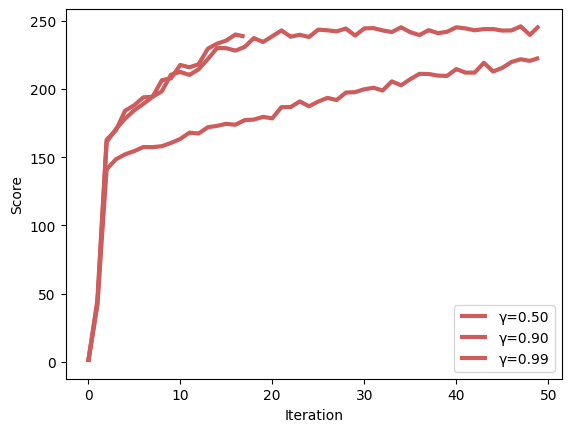

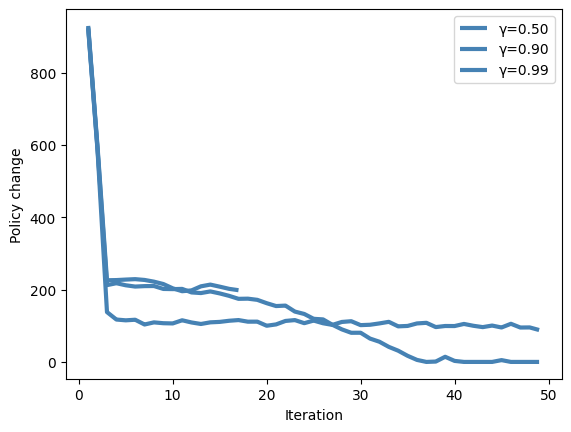

In [80]:
γs = [0.5,0.9,0.99]
arm_nbr = 2
α_res = 60
x_res = 10
ε = 0.001
max_iter = 50
policies = {}
records = {}
for γ in γs:
    game = Reacher(arm_nbr=arm_nbr, α_res=α_res, x_res=x_res, reward_reach=20, reward_gradient_multiplier=0)
    π,rec = valueIteration(game, ε, γ, max_iter=max_iter)
    policies["γ={:0.2f}".format(γ)] = π
    records["γ={:0.2f}".format(γ)] = rec
filename = 'R{}_{}_{}_VI_noDistanceReward_γs={}'.format(arm_nbr,α_res,x_res,γs)
outfile = open(filename,'wb')
pickle.dump((policies,records),outfile)
outfile.close()
analysis(records)

100%|██████████| 200/200 [00:00<00:00, 3284.52it/s]


Iteration #0


100%|██████████| 200/200 [00:00<00:00, 2324.15it/s]


perf = (4.77405747492616, 6.1060344698283195, 8.103726563840441)


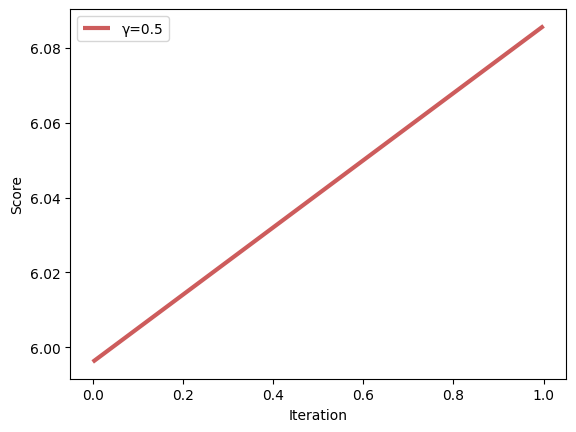

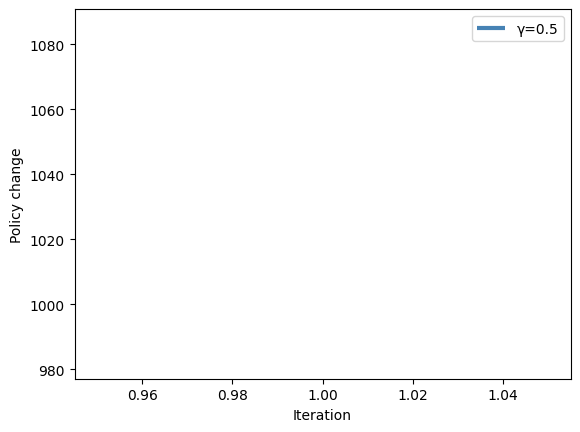

In [85]:
eval_iter = 1
γs = [0.5]
arm_nbr = 2
α_res = 60
x_res = 10
ε = 0.001
max_iter = 1
policies = {}
records = {}

for γ in γs:
    game = Reacher(arm_nbr=arm_nbr, α_res=α_res, x_res=x_res, reward_reach=20)
    π,rec = policyIteration(game, γ, eval_iter=eval_iter, max_iter=max_iter)
    policies["γ={:0.1f}".format(γ)] = π
    records["γ={:0.1f}".format(γ)] = rec
filename = 'R{}_{}_{}_PI_γs={}'.format(arm_nbr,α_res,x_res,γs)
outfile = open(filename,'wb')
pickle.dump((policies,records),outfile)
outfile.close()
analysis(records)

100%|██████████| 1000/1000 [24:26<00:00,  1.47s/it]


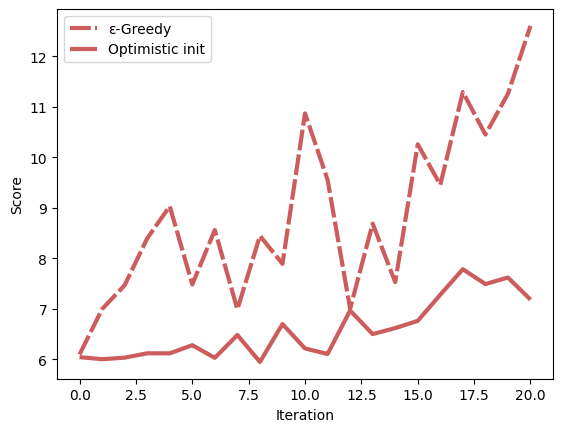

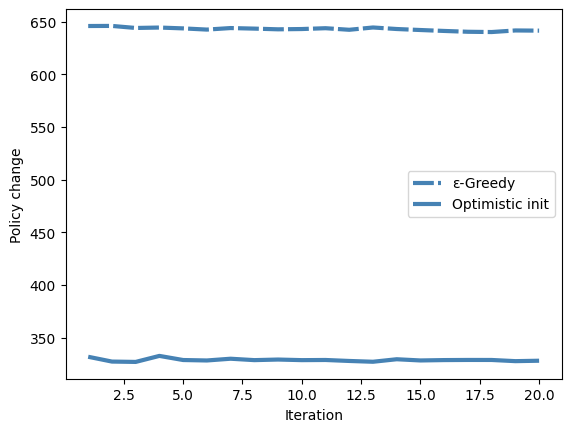

In [83]:
arm_nbr = 2
α_res = 60
x_res = 10
γ = 0.5
α = 0.5
qinit = 0
qpolicy = εGreedy
nbr_episode = 1000
nbr_turns = 100
rec_period = 50
policies = {}
records = {}

qpolicy_args = {'epsilon':0.2}
game = Reacher(arm_nbr=arm_nbr, α_res=α_res, x_res=x_res, reward_reach=20)
π,rec = Qlearning(game, γ, α, qpolicy=qpolicy, qpolicy_args=qpolicy_args, qinit=0, nbr_turns=nbr_turns, nbr_episode=nbr_episode, rec_period=rec_period, verbose=False)
policies["ε-Greedy"] = π
records["ε-Greedy"] = rec

qpolicy_args = {'epsilon':0.05}
game = Reacher(arm_nbr=arm_nbr, α_res=α_res, x_res=x_res, reward_reach=20)
π,rec = Qlearning(game, γ, α, qpolicy=qpolicy, qpolicy_args=qpolicy_args, qinit=5, nbr_turns=nbr_turns, nbr_episode=nbr_episode, rec_period=rec_period, verbose=False)
policies["Optimistic init"] = π
records["Optimistic init"] = rec

filename = 'R{}_{}_{}_QL_exploStrats'.format(arm_nbr,α_res,x_res)
outfile = open(filename,'wb')
pickle.dump((policies,records),outfile)
outfile.close()
analysis(records)

100%|██████████| 1000/1000 [59:10<00:00,  3.55s/it]


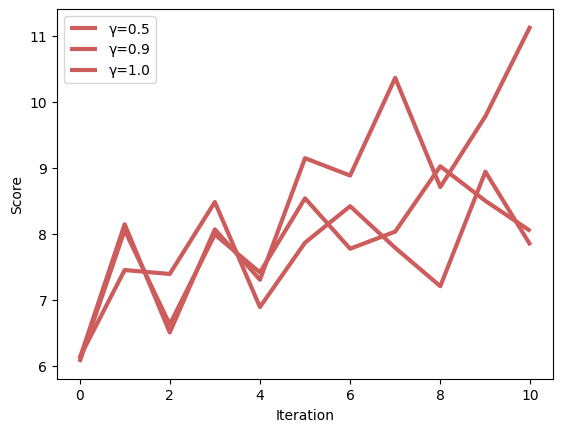

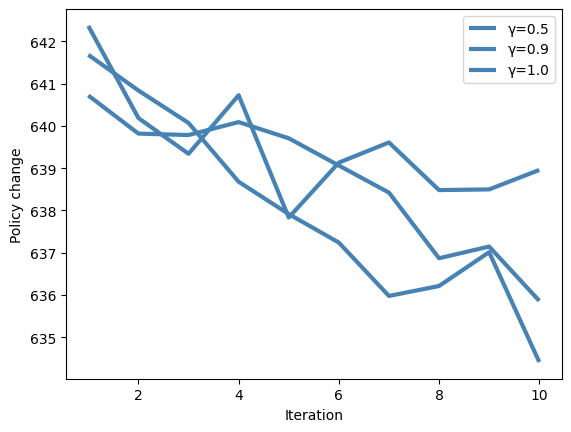

In [84]:
γs = [0.5,0.9,0.99]
arm_nbr = 2
α_res = 60
x_res = 10
α = 0.5
qinit = 0

qpolicy = εGreedy
qpolicy_args = {'epsilon':0.2}
nbr_episode = 1000
nbr_turns = 200
rec_period = 100
policies = {}
records = {}
for γ in γs:
    game = Reacher(arm_nbr=arm_nbr, α_res=α_res, x_res=x_res, reward_reach=20)
    π,rec = Qlearning(game, γ, α, qpolicy=qpolicy, qpolicy_args=qpolicy_args, qinit=0, nbr_turns=nbr_turns, nbr_episode=nbr_episode, rec_period=rec_period, verbose=False)
    policies["γ={:0.1f}".format(γ)] = π
    records["γ={:0.1f}".format(γ)] = rec
filename = 'R{}_{}_{}_QL_γs={}'.format(arm_nbr,α_res,x_res,γs)
outfile = open(filename,'wb')
pickle.dump((policies,records),outfile)
outfile.close()
analysis(records)

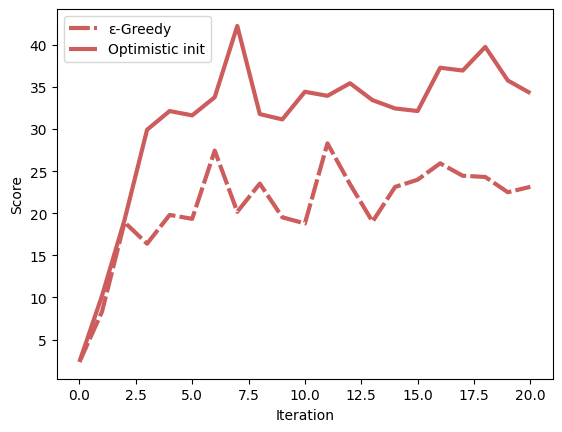

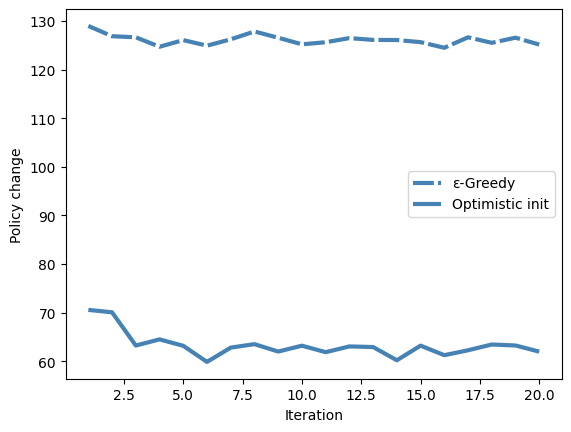

{'ε-Greedy': [((2.0110420407059273, 2.3440762925518994, 2.750158133054385), 0), ((2.11225463453385, 8.312754511552718, 62.509155315107044), 128.98061869908983), ((2.079760619181425, 18.935770373654407, 62.50716879144686), 126.86212988910441), ((2.0800402038194585, 16.387273150752556, 102.3972795238044), 126.64122551523259), ((2.027175407416564, 19.80398861765784, 122.31258496859309), 124.69562943423479), ((2.0466890367565864, 19.34150354137119, 102.55461838391909), 126.0634760745554), ((2.1345318652831997, 27.449046804298757, 142.20951486130136), 124.91997438360288), ((2.08339500334944, 20.173182605790828, 122.36259822024988), 126.22202660391727), ((2.1013912760468663, 23.525301989784698, 102.397721409814), 127.83583222242503), ((2.1346180729761666, 19.521550244548404, 122.33445530966571), 126.54643416548726), ((2.0466890367565864, 18.79189677846509, 202.2241945265017), 125.19584657647394), ((2.0814083804060686, 28.307823286320325, 142.26169473986693), 125.62245022288015), ((2.07702779

In [79]:
filename="R2_20_6_QL_exploStrats"
with open(filename, 'rb') as file:
    # Load the data from the file
    data_tuple = pickle.load(file)[1]
    analysis(data_tuple)
    print(data_tuple)

In [78]:
def analysis(records):
    # plotArgs = {'γ=0.5':{'dashes':[2,1]}, 'γ=0.9':{'dashes':[4,1]}, 'γ=0.99':{'dashes':[2,0]}, 'default':{'dashes':[0.5,0]}}
    # plotArgs = {'ε=0.00':{'alpha':1}, 'ε=0.25':{'alpha':0.8}, 'ε=0.50':{'alpha':0.6}, 'ε=0.75':{'alpha':0.4}, 'ε=1.00':{'alpha':0.2}, 'default':{'dashes':[0.5,0]}}
    # plotArgs = {'α=0.01':{'alpha':1}, 'α=0.04':{'alpha':0.8}, 'α=0.10':{'alpha':0.6}, 'α=0.25':{'alpha':0.4}, 'α=0.50':{'alpha':0.2}, 'α=0.90':{'alpha':0.1}, 'default':{'dashes':[0.5,0]}}
    plotArgs = {'Optimistic init':{'dashes':[2,0]}, 'ε-Greedy':{'dashes':[5,1]}, 'εp-Random':{'dashes':[3,1]}, 'εβp-Random':{'dashes':[1,1]}, 'default':{'dashes':[0.5,0]}}
    for label,rec in records.items():
        perfs, dists = zip(*rec)
        perfs = perfs[:50]
        dists = dists[:50]
        plt.figure(1)
        plt.plot(range(len(perfs)), [entry[1] for entry in perfs], color="IndianRed", linewidth=3, label=label, **plotArgs.get(label, plotArgs['default']))
        # plt.fill_between(range(len(perfs)), [entry[0] for entry in perfs], [entry[2] for entry in perfs], color="IndianRed", alpha=0.15)
        plt.xlabel("Iteration")
        plt.ylabel("Score")
        plt.legend()
        plt.figure(2)
        plt.plot(range(1,len(dists)), dists[1:], color="SteelBlue", linewidth=3, label=label, **plotArgs.get(label, plotArgs['default']))
        plt.xlabel("Iteration")
        plt.ylabel("Policy change")
        plt.legend()
    plt.show()